In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.11.0'

In [3]:
# 检查GPU是否可用
torch.cuda.is_available()

False

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cpu')

pytorch中使用GPU进行训练

1. 把模型转移到GPU上. 

2. 将每一批次的训练数据转移到GPU上. 

# torchvision 内置了常用的数据集和常见的模型. 

In [6]:
import torchvision

In [7]:
from torchvision import datasets, transforms

transforms.ToTensor 

1. 把数据转化为tensor

2. 数据的值转化为0到1之间. 

3. 会把channel放到第一个维度上.

In [8]:
# transforms用来做数据增强, 数据预处理等功能的. 
transformation = transforms.Compose([transforms.ToTensor(),])

# 数据下载

In [9]:
train_ds = datasets.MNIST('./', train=True, transform=transformation, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



In [10]:
# 测试数据集
test_ds = datasets.MNIST('./', train=False, transform=transformation, download=True)

In [11]:
# 转换成dataloader
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

In [12]:
images, labels = next(iter(train_dl))

In [13]:
# pytorch中图片的表现形式[batch, channel, hight, width]
images.shape

torch.Size([64, 1, 28, 28])

In [14]:
labels

tensor([7, 1, 4, 8, 9, 1, 5, 1, 9, 6, 6, 5, 6, 1, 1, 4, 2, 0, 2, 3, 4, 9, 5, 1,
        2, 6, 6, 2, 0, 9, 5, 2, 0, 0, 0, 0, 5, 7, 7, 8, 4, 4, 2, 4, 2, 6, 7, 8,
        4, 4, 5, 9, 0, 5, 2, 0, 3, 8, 1, 9, 3, 0, 2, 0])

In [15]:
img = images[0]

In [16]:
img.shape

torch.Size([1, 28, 28])

In [17]:
img = img.numpy()

In [18]:
img = np.squeeze(img)

In [19]:
img.shape

(28, 28)

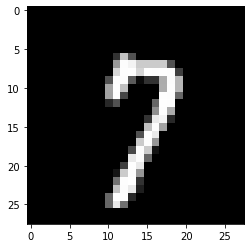

In [20]:
plt.imshow(img, cmap='gray')

# 创建模型

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)# in: 64, 1, 28 , 28 -> out: 64, 32, 26, 26
        self.pool = nn.MaxPool2d((2, 2)) # out: 64, 32, 13, 13
        self.conv2 = nn.Conv2d(32, 64, 3)# in: 64, 32, 13, 13 -> out: 64, 64, 11, 11
        # 再加一层池化操作, in: 64, 64, 11, 11  --> out: 64, 64, 5, 5
        self.linear_1 = nn.Linear(64 * 5 * 5, 256)
        self.linear_2 = nn.Linear(256, 10)
        
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # flatten
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

In [22]:
model = Model()

In [23]:
# 把model拷到GPU上面去
model.to(device)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (linear_1): Linear(in_features=1600, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)

In [24]:
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 配置网络

In [26]:
def fit(epoch, model, train_loader, test_loader):
    correct = 0
    total = 0
    running_loss = 0
    
    for x, y in train_loader:
        # 把数据放到GPU上去. 
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
            
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
        
    # 测试过程
    test_correct = 0
    test_total = 0
    test_running_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = test_correct / test_total

    print('epoch: ', epoch,
         'loss: ', round(epoch_loss, 3),
         'accuracy: ', round(epoch_acc, 3),
         'test_loss: ', round(test_epoch_loss, 3),
         'test_accuracy: ', round(test_epoch_acc,3))
    return epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc

# 模型训练

In [27]:
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    epoch_loss, epoch_acc, test_epoch_loss, test_epoch_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    test_loss.append(epoch_loss)
    test_acc.append(epoch_acc)

epoch:  0 loss:  0.003 accuracy:  0.949 test_loss:  0.0 test_accuracy:  0.984
epoch:  1 loss:  0.001 accuracy:  0.986 test_loss:  0.0 test_accuracy:  0.989
epoch:  2 loss:  0.001 accuracy:  0.99 test_loss:  0.0 test_accuracy:  0.989
epoch:  3 loss:  0.0 accuracy:  0.993 test_loss:  0.0 test_accuracy:  0.99
epoch:  4 loss:  0.0 accuracy:  0.995 test_loss:  0.0 test_accuracy:  0.991
epoch:  5 loss:  0.0 accuracy:  0.995 test_loss:  0.0 test_accuracy:  0.989
epoch:  6 loss:  0.0 accuracy:  0.997 test_loss:  0.0 test_accuracy:  0.991
epoch:  7 loss:  0.0 accuracy:  0.997 test_loss:  0.0 test_accuracy:  0.99
epoch:  8 loss:  0.0 accuracy:  0.998 test_loss:  0.0 test_accuracy:  0.992
epoch:  9 loss:  0.0 accuracy:  0.997 test_loss:  0.0 test_accuracy:  0.992
epoch:  10 loss:  0.0 accuracy:  0.998 test_loss:  0.0 test_accuracy:  0.991
epoch:  11 loss:  0.0 accuracy:  0.998 test_loss:  0.0 test_accuracy:  0.992
epoch:  12 loss:  0.0 accuracy:  0.999 test_loss:  0.0 test_accuracy:  0.992
epoch: